In [ ]:
import os, sys
import copy
import collections import OrderedDict
import cv2
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functinal as F
from torchvision import transforms as transforms

from utils.inverter import StyleGANInverter
import lpips

dlatent_path = "/path/to/100K_dlatents_npy_file"
mean_path = "/path/to/mean_npy_file"
cov_path = "/path/to/cov_npy_file"
Target_path  = "/path/to/target_img"

In [ ]:
# StyleGANの層数
s = 14
# optimizer parameter
INIT_LEARNING_RATE      = 0.1
INIT_NOISE_FACTOR       = 0.05
LR_RAMPDOWN_LENGTH      = 0.25
LR_RAMPUP_LENGTH        = 0.05
# dlatent noise parameter
NOISE_RAMP_LENGTH       = 0.75

def Leaky_ReLU_5(x):
  a = copy.deepcopy(x)
  a[a<0] *= 5
  return a


inverter = StyleGANInverter(
            'styleganinv_bedroom256',
            learning_rate=0.01,
            iteration=100,
            reconstruction_loss_weight=1.0,
            perceptual_loss_weight=5e-5,
            regularization_loss_weight=2.0,
            logger=None
        )

inverter = inverter.G

generator = inverter.net.cuda()

for param in generator.parameters():
  param.requires_grad = False

dlatent = np.load(dlatent_path)
dlatent = dlatent.reshape((-1, 14*512))
G_dlatent = Leaky_ReLU_5(dlatent)

# 正則化項に用いる平均と分散
mean = np.load(mean_path)
cov = np.load(cov_path)
inv_cov = np.linalg.inv(cov)

dlatent_avg = np.mean(dlatent[:10000],axis=0)
dlatent_std = (np.sum((dlatent[:10000]-dlatent_avg)**2) / 10000)**0.5

# Inversionしたい目的の画像
target = cv2.resize(cv2.imread(Target_path)[:,:,::-1], (224, 224))
target = np.array(target).transpose((2, 0, 1))
target = (target - 125.0)/125.0

image_size = 224

use_gpu=True
spatial = False

loss_fn = lpips.LPIPS(net='vgg', spatial=spatial)

if(use_gpu):
  loss_fn.cuda()

transform = transforms.Compose(
    [transforms.Resize(224), transforms.ToTensor()]
)

[2022-03-24 15:58:41,513][INFO] Build network for module `generator` in model `styleganinv_bedroom256`.
[2022-03-24 15:58:41,822][INFO] Loading pytorch weights from `models/pretrain/styleganinv_bedroom256_generator.pth`.
[2022-03-24 15:58:42,049][INFO] Successfully loaded!
[2022-03-24 15:58:50,623][INFO] Current `lod` is 0.0.
[2022-03-24 15:58:50,625][INFO] Build network for module `encoder` in model `styleganinv_bedroom256`.
[2022-03-24 15:58:51,552][INFO] Loading pytorch weights from `models/pretrain/styleganinv_bedroom256_encoder.pth`.
[2022-03-24 15:58:53,208][INFO] Successfully loaded!
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/acd13362wp/indomai/idinvert_pytorch/lpips/weights/v0.1/vgg.pth


In [ ]:
def training(optimizer, embd_w, i, inv_cov, mode='W'):
  assert mode in ['W', 'W+']

  epochs = 10000
  t = i/epochs
  dlatent_noise = dlatent_std * INIT_NOISE_FACTOR * max(0.0, 1.0 - t / NOISE_RAMP_LENGTH) ** 2
  lr_ramp = min(1.0, (1.0-t) / LR_RAMPDOWN_LENGTH)
  lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
  lr_ramp = lr_ramp * min(1.0, t / LR_RAMPDOWN_LENGTH)
  learning_rate = INIT_LEARNING_RATE * lr_ramp
    
  optimizer.param_groups[0]['lr'] = learning_rate
  optimizer.zero_grad()
    
  eps = 1e-14

  inp = embd_w.to('cpu') + torch.tensor(dlatent_noise * np.random.normal(size=(1, 1, 512)), dtype=torch.float32)
  
  inp = inp.to('cuda')
  embd_img = generator.synthesis(inp)
  image = inverter.postprocess(embd_img.to('cpu').detach().numpy().copy())[0]
  embd_img = F.interpolate(embd_img, (224,224), mode='area')
  
  lpips_Loss = loss_fn.forward(embd_img, torch.tensor(target[np.newaxis], dtype=torch.float32, device='cuda'))
  lpips_Loss = lpips_Loss.squeeze()

  Reconstruct_Loss = torch.sum((embd_img.to('cpu')/255 - torch.tensor(target[np.newaxis], dtype=torch.float32)/255)**2) / (224*224*3)
  v = nn.LeakyReLU(negative_slope=5)(embd_w.to('cpu')) - torch.tensor(mean)
  v = torch.reshape(v, (1, -1))
  inv_cov = torch.from_numpy(inv_cov).float()
  Reg_Loss = torch.matmul(torch.matmul(v, inv_cov), v.T)
  Total_Loss = 0.8*lpips_Loss + Reconstruct_Loss.to('cuda')+eps*Reg_Loss.to('cuda')
  print('Reg_Loss: %lf'%Reg_Loss)
  print('Loss : %lf'%Total_Loss)
 
  #print('Loss : %lf , LPIPS : %lf , Rec : %lf, Reg : %lf'%(Total_Loss,lpips_Loss,Reconstruct_Loss,Reg_Loss))
  Total_Loss.backward()
  optimizer.step()

  if i%100==0:
    plt.imshow(image)
    plt.axis("off")
    plt.show()
  

In [ ]:
Embd_w = torch.tensor(np.mean(dlatent,axis=0).reshape((1, 14, 512)), requires_grad=True, device='cuda')
Optimizer = torch.optim.Adam([Embd_w], lr=0.05)

0
Reg_Loss: 2266372608.000000
Loss : 0.652726


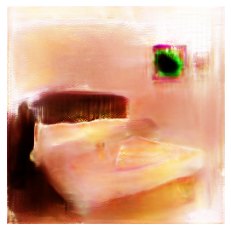

1
Reg_Loss: 2266372608.000000
Loss : 0.638525
2
Reg_Loss: 2263229184.000000
Loss : 0.625441
3
Reg_Loss: 2253063936.000000
Loss : 0.626680
4
Reg_Loss: 2233300224.000000
Loss : 0.656523
5
Reg_Loss: 2209053952.000000
Loss : 0.631475
6
Reg_Loss: 2173121536.000000
Loss : 0.692449
7
Reg_Loss: 2130065920.000000
Loss : 0.700006
8
Reg_Loss: 2093604352.000000
Loss : 0.623572
9
Reg_Loss: 2049210880.000000
Loss : 0.659696
10
Reg_Loss: 2000619136.000000
Loss : 0.642695
11
Reg_Loss: 1950216192.000000
Loss : 0.626620
12
Reg_Loss: 1891783936.000000
Loss : 0.720175
13
Reg_Loss: 1831706880.000000
Loss : 0.594369
14
Reg_Loss: 1765005824.000000
Loss : 0.698196
15
Reg_Loss: 1696336768.000000
Loss : 0.704790
16
Reg_Loss: 1632283776.000000
Loss : 0.602224
17
Reg_Loss: 1557561344.000000
Loss : 0.645787
18
Reg_Loss: 1479191040.000000
Loss : 0.665681
19
Reg_Loss: 1405772160.000000
Loss : 0.633475
20
Reg_Loss: 1337320320.000000
Loss : 0.667737
21
Reg_Loss: 1262295296.000000
Loss : 0.630944
22
Reg_Loss: 117684352

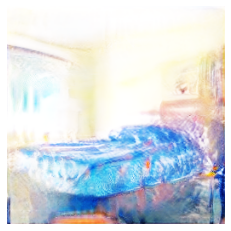

101
Reg_Loss: 40384096.000000
Loss : 0.608049
102
Reg_Loss: 48121852.000000
Loss : 0.594220
103
Reg_Loss: 52019636.000000
Loss : 0.581882
104
Reg_Loss: 51547168.000000
Loss : 0.603339
105
Reg_Loss: 16586727.000000
Loss : 0.605321
106
Reg_Loss: 58896752.000000
Loss : 0.612132
107
Reg_Loss: 103960296.000000
Loss : 0.575337
108
Reg_Loss: 98863936.000000
Loss : 0.597337
109
Reg_Loss: 62578844.000000
Loss : 0.596849
110
Reg_Loss: 17854064.000000
Loss : 0.557958
111
Reg_Loss: 77998600.000000
Loss : 0.592104
112
Reg_Loss: 59107040.000000
Loss : 0.608586
113
Reg_Loss: 7473133.000000
Loss : 0.570598
114
Reg_Loss: 67698664.000000
Loss : 0.619907
115
Reg_Loss: 79938792.000000
Loss : 0.617152
116
Reg_Loss: 81397296.000000
Loss : 0.616178
117
Reg_Loss: 30900144.000000
Loss : 0.650205
118
Reg_Loss: 92007488.000000
Loss : 0.578239
119
Reg_Loss: 134561040.000000
Loss : 0.603812
120
Reg_Loss: 73420968.000000
Loss : 0.668057
121
Reg_Loss: 32203864.000000
Loss : 0.562077
122
Reg_Loss: 62968244.000000
Los

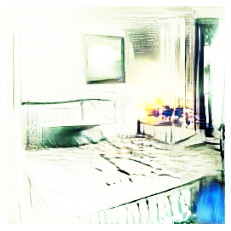

201
Reg_Loss: 1275840256.000000
Loss : 0.560675
202
Reg_Loss: 62553696.000000
Loss : 0.546340
203
Reg_Loss: 779791232.000000
Loss : 0.557228
204
Reg_Loss: 1007306880.000000
Loss : 0.574785
205
Reg_Loss: 923382976.000000
Loss : 0.572090
206
Reg_Loss: 557651776.000000
Loss : 0.548753
207
Reg_Loss: 310157984.000000
Loss : 0.567295
208
Reg_Loss: 673550464.000000
Loss : 0.554318
209
Reg_Loss: 487144288.000000
Loss : 0.591829
210
Reg_Loss: 190744592.000000
Loss : 0.564364
211
Reg_Loss: 153257392.000000
Loss : 0.560253
212
Reg_Loss: 474390208.000000
Loss : 0.585484
213
Reg_Loss: 516284672.000000
Loss : 0.570811
214
Reg_Loss: 97937744.000000
Loss : 0.569584
215
Reg_Loss: 95651328.000000
Loss : 0.545244
216
Reg_Loss: 386941952.000000
Loss : 0.556754
217
Reg_Loss: 205901040.000000
Loss : 0.567683
218
Reg_Loss: 686694848.000000
Loss : 0.576432
219
Reg_Loss: 678591296.000000
Loss : 0.565280
220
Reg_Loss: 374989152.000000
Loss : 0.592861
221
Reg_Loss: 689368832.000000
Loss : 0.581218
222
Reg_Loss: 

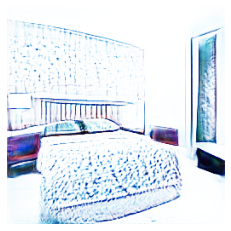

301
Reg_Loss: 374024736.000000
Loss : 0.553621
302
Reg_Loss: 1422543360.000000
Loss : 0.565971
303
Reg_Loss: 212073264.000000
Loss : 0.554030
304
Reg_Loss: 2808922112.000000
Loss : 0.536188
305
Reg_Loss: 3348483072.000000
Loss : 0.537963
306
Reg_Loss: 1438849536.000000
Loss : 0.552701
307
Reg_Loss: 3002186496.000000
Loss : 0.542170
308
Reg_Loss: 3723351552.000000
Loss : 0.550297
309
Reg_Loss: 1315713280.000000
Loss : 0.559476
310
Reg_Loss: 3669657088.000000
Loss : 0.576392
311
Reg_Loss: 5511838208.000000
Loss : 0.531636
312
Reg_Loss: 4386552832.000000
Loss : 0.538246
313
Reg_Loss: 401545088.000000
Loss : 0.558058
314
Reg_Loss: 7473239552.000000
Loss : 0.548547
315
Reg_Loss: 10957849600.000000
Loss : 0.519815
316
Reg_Loss: 9451420672.000000
Loss : 0.554773
317
Reg_Loss: 3532513536.000000
Loss : 0.545921
318
Reg_Loss: 4840134144.000000
Loss : 0.550040
319
Reg_Loss: 8429002240.000000
Loss : 0.531528
320
Reg_Loss: 9510582272.000000
Loss : 0.528874
321
Reg_Loss: 8017327616.000000
Loss : 0.5

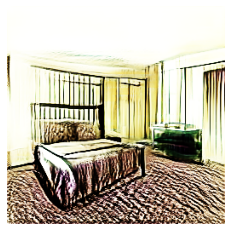

401
Reg_Loss: 390292064.000000
Loss : 0.525818
402
Reg_Loss: 274604192.000000
Loss : 0.539153
403
Reg_Loss: 546890048.000000
Loss : 0.522951
404
Reg_Loss: 582839488.000000
Loss : 0.527429
405
Reg_Loss: 91994408.000000
Loss : 0.557766
406
Reg_Loss: 335390496.000000
Loss : 0.513074
407
Reg_Loss: 186675568.000000
Loss : 0.528287
408
Reg_Loss: 167920064.000000
Loss : 0.508501
409
Reg_Loss: 795043392.000000
Loss : 0.515875
410
Reg_Loss: 870285504.000000
Loss : 0.545696
411
Reg_Loss: 249071408.000000
Loss : 0.501901
412
Reg_Loss: 138889456.000000
Loss : 0.501969
413
Reg_Loss: 1058093184.000000
Loss : 0.524360
414
Reg_Loss: 580545536.000000
Loss : 0.529621
415
Reg_Loss: 1466904576.000000
Loss : 0.520481
416
Reg_Loss: 1212545024.000000
Loss : 0.525469
417
Reg_Loss: 1087228032.000000
Loss : 0.510186
418
Reg_Loss: 1258805888.000000
Loss : 0.530743
419
Reg_Loss: 883485120.000000
Loss : 0.517494
420
Reg_Loss: 861137216.000000
Loss : 0.505823
421
Reg_Loss: 1659810688.000000
Loss : 0.521966
422
Reg_

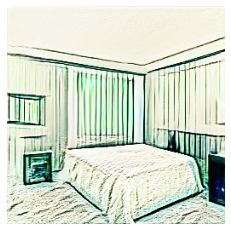

501
Reg_Loss: 5329563136.000000
Loss : 0.493590
502
Reg_Loss: 5542812160.000000
Loss : 0.497397
503
Reg_Loss: 3606917120.000000
Loss : 0.499351
504
Reg_Loss: 652178176.000000
Loss : 0.514940
505
Reg_Loss: 2718540288.000000
Loss : 0.507414
506
Reg_Loss: 1171749888.000000
Loss : 0.483272
507
Reg_Loss: 2609654784.000000
Loss : 0.486949
508
Reg_Loss: 3503672320.000000
Loss : 0.506367
509
Reg_Loss: 1991972352.000000
Loss : 0.517226
510
Reg_Loss: 1236129664.000000
Loss : 0.497144
511
Reg_Loss: 2409900800.000000
Loss : 0.505850
512
Reg_Loss: 1583524352.000000
Loss : 0.551345
513
Reg_Loss: 973565376.000000
Loss : 0.500104
514
Reg_Loss: 1239067904.000000
Loss : 0.509142
515
Reg_Loss: 455132224.000000
Loss : 0.517512
516
Reg_Loss: 1028918720.000000
Loss : 0.496637
517
Reg_Loss: 756337152.000000
Loss : 0.504210
518
Reg_Loss: 590178752.000000
Loss : 0.515651
519
Reg_Loss: 793245376.000000
Loss : 0.519811
520
Reg_Loss: 100546184.000000
Loss : 0.502190
521
Reg_Loss: 2426913536.000000
Loss : 0.491763

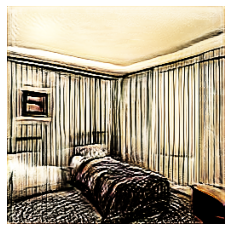

601
Reg_Loss: 239068688.000000
Loss : 0.498740
602
Reg_Loss: 2150355712.000000
Loss : 0.510435
603
Reg_Loss: 2778755072.000000
Loss : 0.530130
604
Reg_Loss: 1198802560.000000
Loss : 0.491736
605
Reg_Loss: 2122810496.000000
Loss : 0.517751
606
Reg_Loss: 2957284608.000000
Loss : 0.504956
607
Reg_Loss: 1575479936.000000
Loss : 0.493151
608
Reg_Loss: 2186604032.000000
Loss : 0.503272
609
Reg_Loss: 3281873152.000000
Loss : 0.492664
610
Reg_Loss: 1749847168.000000
Loss : 0.508233
611
Reg_Loss: 1817134336.000000
Loss : 0.484181
612
Reg_Loss: 2841352960.000000
Loss : 0.500739
613
Reg_Loss: 1521226624.000000
Loss : 0.495496
614
Reg_Loss: 2069900800.000000
Loss : 0.496995
615
Reg_Loss: 3053673216.000000
Loss : 0.491003
616
Reg_Loss: 1517544064.000000
Loss : 0.485389
617
Reg_Loss: 2920782848.000000
Loss : 0.490668
618
Reg_Loss: 3395071744.000000
Loss : 0.486515
619
Reg_Loss: 677176832.000000
Loss : 0.480701
620
Reg_Loss: 4383675904.000000
Loss : 0.507921
621
Reg_Loss: 5632126464.000000
Loss : 0.5

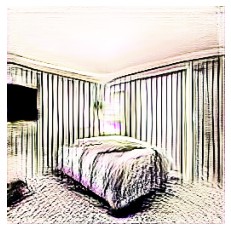

701
Reg_Loss: 3748779520.000000
Loss : 0.484341
702
Reg_Loss: 2483334912.000000
Loss : 0.528832
703
Reg_Loss: 1559592448.000000
Loss : 0.479582
704
Reg_Loss: 2766848000.000000
Loss : 0.479497
705
Reg_Loss: 1563016704.000000
Loss : 0.554961
706
Reg_Loss: 1990994688.000000
Loss : 0.475999
707
Reg_Loss: 2395173120.000000
Loss : 0.480753
708
Reg_Loss: 194264848.000000
Loss : 0.480648
709
Reg_Loss: 105433152.000000
Loss : 0.468124
710
Reg_Loss: 1989632256.000000
Loss : 0.482866
711
Reg_Loss: 1603190656.000000
Loss : 0.487487
712
Reg_Loss: 1715799552.000000
Loss : 0.490458
713
Reg_Loss: 1564010240.000000
Loss : 0.488897
714
Reg_Loss: 1638983168.000000
Loss : 0.475684
715
Reg_Loss: 2000221568.000000
Loss : 0.472836
716
Reg_Loss: 527072480.000000
Loss : 0.490936
717
Reg_Loss: 367493504.000000
Loss : 0.460900
718
Reg_Loss: 1859810048.000000
Loss : 0.462840
719
Reg_Loss: 1098675840.000000
Loss : 0.486170
720
Reg_Loss: 2606587904.000000
Loss : 0.492871
721
Reg_Loss: 3055435776.000000
Loss : 0.479

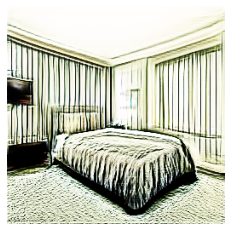

801
Reg_Loss: 1124071168.000000
Loss : 0.476996
802
Reg_Loss: 741304192.000000
Loss : 0.489815
803
Reg_Loss: 5343964672.000000
Loss : 0.460074
804
Reg_Loss: 4093879552.000000
Loss : 0.499538
805
Reg_Loss: 1953268864.000000
Loss : 0.506858
806
Reg_Loss: 1842147840.000000
Loss : 0.507652
807
Reg_Loss: 2502071808.000000
Loss : 0.472308
808
Reg_Loss: 2754068992.000000
Loss : 0.458884
809
Reg_Loss: 1180027136.000000
Loss : 0.460643
810
Reg_Loss: 932643456.000000
Loss : 0.468356
811
Reg_Loss: 2701766400.000000
Loss : 0.452511
812
Reg_Loss: 2325124352.000000
Loss : 0.481575
813
Reg_Loss: 2487186176.000000
Loss : 0.472843
814
Reg_Loss: 3088913408.000000
Loss : 0.473736
815
Reg_Loss: 124570208.000000
Loss : 0.495602
816
Reg_Loss: 6358231040.000000
Loss : 0.462285
817
Reg_Loss: 7967542272.000000
Loss : 0.464142
818
Reg_Loss: 4929733120.000000
Loss : 0.467314
819
Reg_Loss: 978000192.000000
Loss : 0.477106
820
Reg_Loss: 1781046400.000000
Loss : 0.481109
821
Reg_Loss: 2539327744.000000
Loss : 0.452

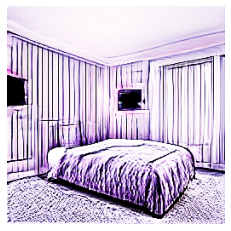

901
Reg_Loss: 83091472384.000000
Loss : 0.468588
902
Reg_Loss: 65731969024.000000
Loss : 0.449718
903
Reg_Loss: 41744461824.000000
Loss : 0.460482
904
Reg_Loss: 26111334400.000000
Loss : 0.477813
905
Reg_Loss: 4280321280.000000
Loss : 0.448459
906
Reg_Loss: 71030333440.000000
Loss : 0.469201
907
Reg_Loss: 56472059904.000000
Loss : 0.474171
908
Reg_Loss: 59900190720.000000
Loss : 0.460476
909
Reg_Loss: 74840440832.000000
Loss : 0.449728
910
Reg_Loss: 17745297408.000000
Loss : 0.439968
911
Reg_Loss: 73159106560.000000
Loss : 0.466745
912
Reg_Loss: 84651130880.000000
Loss : 0.464563
913
Reg_Loss: 61882150912.000000
Loss : 0.458068
914
Reg_Loss: 48260833280.000000
Loss : 0.455357
915
Reg_Loss: 31266885632.000000
Loss : 0.450147
916
Reg_Loss: 50625007616.000000
Loss : 0.467500
917
Reg_Loss: 41214984192.000000
Loss : 0.470801
918
Reg_Loss: 146453708800.000000
Loss : 0.450412
919
Reg_Loss: 118454140928.000000
Loss : 0.455240
920
Reg_Loss: 100647534592.000000
Loss : 0.493150
921
Reg_Loss: 1117

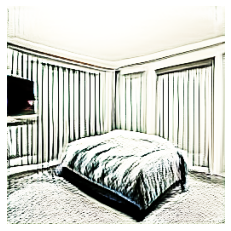

1001
Reg_Loss: 10389284864.000000
Loss : 0.442879
1002
Reg_Loss: 71509975040.000000
Loss : 0.469280
1003
Reg_Loss: 20956272640.000000
Loss : 0.444287
1004
Reg_Loss: 174948581376.000000
Loss : 0.462299
1005
Reg_Loss: 141175472128.000000
Loss : 0.441563
1006
Reg_Loss: 10729823232.000000
Loss : 0.443268
1007
Reg_Loss: 42936246272.000000
Loss : 0.439761
1008
Reg_Loss: 44053544960.000000
Loss : 0.435960
1009
Reg_Loss: 29363750912.000000
Loss : 0.441031
1010
Reg_Loss: 10080684032.000000
Loss : 0.445259
1011
Reg_Loss: 15340298240.000000
Loss : 0.444810
1012
Reg_Loss: 20696776704.000000
Loss : 0.446147
1013
Reg_Loss: 20477083648.000000
Loss : 0.465956
1014
Reg_Loss: 5950991360.000000
Loss : 0.446741
1015
Reg_Loss: 7028709376.000000
Loss : 0.455530
1016
Reg_Loss: 8389840384.000000
Loss : 0.429078
1017
Reg_Loss: 1045758912.000000
Loss : 0.449091
1018
Reg_Loss: 9575007232.000000
Loss : 0.472762
1019
Reg_Loss: 9374729216.000000
Loss : 0.435493
1020
Reg_Loss: 4435139072.000000
Loss : 0.446672
1021


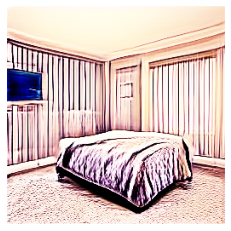

1101
Reg_Loss: 115979829248.000000
Loss : 0.431639
1102
Reg_Loss: 144082567168.000000
Loss : 0.434931
1103
Reg_Loss: 25444538368.000000
Loss : 0.445234
1104
Reg_Loss: 56368087040.000000
Loss : 0.440979
1105
Reg_Loss: 11833686016.000000
Loss : 0.431864
1106
Reg_Loss: 53879173120.000000
Loss : 0.426948
1107
Reg_Loss: 43021824000.000000
Loss : 0.424813
1108
Reg_Loss: 27653314560.000000
Loss : 0.433669
1109
Reg_Loss: 151965614080.000000
Loss : 0.442488
1110
Reg_Loss: 66026983424.000000
Loss : 0.434265
1111
Reg_Loss: 134662176768.000000
Loss : 0.428691
1112
Reg_Loss: 168219426816.000000
Loss : 0.422879
1113
Reg_Loss: 126065721344.000000
Loss : 0.479883
1114
Reg_Loss: 53308997632.000000
Loss : 0.416487
1115
Reg_Loss: 50582904832.000000
Loss : 0.421703
1116
Reg_Loss: 122673995776.000000
Loss : 0.429056
1117
Reg_Loss: 157292838912.000000
Loss : 0.434379
1118
Reg_Loss: 145407524864.000000
Loss : 0.444921
1119
Reg_Loss: 115132645376.000000
Loss : 0.462056
1120
Reg_Loss: 66614550528.000000
Loss :

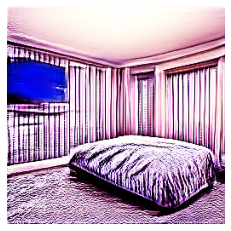

1201
Reg_Loss: 12517555200.000000
Loss : 0.471632
1202
Reg_Loss: 7636606464.000000
Loss : 0.438263
1203
Reg_Loss: 11346876416.000000
Loss : 0.425764
1204
Reg_Loss: 13763702784.000000
Loss : 0.415221
1205
Reg_Loss: 10925843456.000000
Loss : 0.421104
1206
Reg_Loss: 4461921792.000000
Loss : 0.418352
1207
Reg_Loss: 22947897344.000000
Loss : 0.453828
1208
Reg_Loss: 19851870208.000000
Loss : 0.425074
1209
Reg_Loss: 15421960192.000000
Loss : 0.470345
1210
Reg_Loss: 26842418.000000
Loss : 0.456434
1211
Reg_Loss: 31933806592.000000
Loss : 0.403289
1212
Reg_Loss: 2208259072.000000
Loss : 0.403289
1213
Reg_Loss: 63436533760.000000
Loss : 0.426144
1214
Reg_Loss: 62415077376.000000
Loss : 0.439073
1215
Reg_Loss: 31904178176.000000
Loss : 0.407307
1216
Reg_Loss: 3371577088.000000
Loss : 0.421059
1217
Reg_Loss: 21758064640.000000
Loss : 0.450120
1218
Reg_Loss: 37701627904.000000
Loss : 0.420836
1219
Reg_Loss: 45781643264.000000
Loss : 0.465507
1220
Reg_Loss: 69160198144.000000
Loss : 0.420998
1221
Re

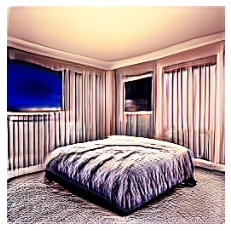

1301
Reg_Loss: 109262962688.000000
Loss : 0.416347
1302
Reg_Loss: 58370576384.000000
Loss : 0.412863
1303
Reg_Loss: 79825223680.000000
Loss : 0.398571
1304
Reg_Loss: 112169656320.000000
Loss : 0.403993
1305
Reg_Loss: 62847762432.000000
Loss : 0.430266
1306
Reg_Loss: 31601307648.000000
Loss : 0.439530
1307
Reg_Loss: 253040640000.000000
Loss : 0.434343
1308
Reg_Loss: 235088117760.000000
Loss : 0.433337
1309
Reg_Loss: 44562231296.000000
Loss : 0.452194
1310
Reg_Loss: 79886401536.000000
Loss : 0.426198
1311
Reg_Loss: 14214276096.000000
Loss : 0.396257
1312
Reg_Loss: 91047501824.000000
Loss : 0.436708
1313
Reg_Loss: 44993167360.000000
Loss : 0.427595
1314
Reg_Loss: 111141429248.000000
Loss : 0.442865
1315
Reg_Loss: 68699324416.000000
Loss : 0.415039
1316
Reg_Loss: 115309985792.000000
Loss : 0.397432
1317
Reg_Loss: 43227992064.000000
Loss : 0.437153
1318
Reg_Loss: 84294598656.000000
Loss : 0.408775
1319
Reg_Loss: 27632216064.000000
Loss : 0.389663
1320
Reg_Loss: 15628597248.000000
Loss : 0.4

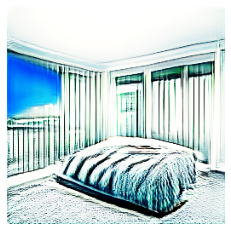

1401
Reg_Loss: 18007543808.000000
Loss : 0.387673
1402
Reg_Loss: 155864170496.000000
Loss : 0.411525
1403
Reg_Loss: 173923811328.000000
Loss : 0.435711
1404
Reg_Loss: 28885452800.000000
Loss : 0.416411
1405
Reg_Loss: 204532596736.000000
Loss : 0.416375
1406
Reg_Loss: 84763811840.000000
Loss : 0.455419
1407
Reg_Loss: 305453236224.000000
Loss : 0.422787
1408
Reg_Loss: 358808387584.000000
Loss : 0.394360
1409
Reg_Loss: 20398995456.000000
Loss : 0.397824
1410
Reg_Loss: 813603225600.000000
Loss : 0.414494
1411
Reg_Loss: 617128919040.000000
Loss : 0.421449
1412
Reg_Loss: 222066081792.000000
Loss : 0.424536
1413
Reg_Loss: 357123719168.000000
Loss : 0.407733
1414
Reg_Loss: 55729524736.000000
Loss : 0.415498
1415
Reg_Loss: 103100538880.000000
Loss : 0.423936
1416
Reg_Loss: 346899087360.000000
Loss : 0.402477
1417
Reg_Loss: 281559859200.000000
Loss : 0.412548
1418
Reg_Loss: 9429442560.000000
Loss : 0.421107
1419
Reg_Loss: 21532753920.000000
Loss : 0.378633
1420
Reg_Loss: 7787303424.000000
Loss :

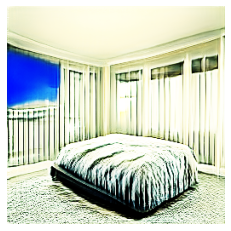

1501
Reg_Loss: 3399678689280.000000
Loss : 0.437439
1502
Reg_Loss: 639194562560.000000
Loss : 0.394425
1503
Reg_Loss: 3240997945344.000000
Loss : 0.428696
1504
Reg_Loss: 1677076070400.000000
Loss : 0.387092
1505
Reg_Loss: 5037774864384.000000
Loss : 0.436487
1506
Reg_Loss: 6567549206528.000000
Loss : 0.459856
1507
Reg_Loss: 3073051197440.000000
Loss : 0.415435
1508
Reg_Loss: 1545527754752.000000
Loss : 0.397037
1509
Reg_Loss: 1395143737344.000000
Loss : 0.385911
1510
Reg_Loss: 2514316427264.000000
Loss : 0.427693
1511
Reg_Loss: 4185312198656.000000
Loss : 0.452101
1512
Reg_Loss: 2800832217088.000000
Loss : 0.391565
1513
Reg_Loss: 622223425536.000000
Loss : 0.404074
1514
Reg_Loss: 180281704448.000000
Loss : 0.382565
1515
Reg_Loss: 1109606268928.000000
Loss : 0.426575
1516
Reg_Loss: 398706278400.000000
Loss : 0.438671
1517
Reg_Loss: 6249481502720.000000
Loss : 0.448177
1518
Reg_Loss: 4486502285312.000000
Loss : 0.465601
1519
Reg_Loss: 3344827678720.000000
Loss : 0.408268
1520
Reg_Loss: 3

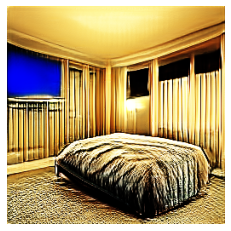

1601
Reg_Loss: 2664947515392.000000
Loss : 0.412589
1602
Reg_Loss: 2023765835776.000000
Loss : 0.382507
1603
Reg_Loss: 2985080651776.000000
Loss : 0.428774
1604
Reg_Loss: 4875563827200.000000
Loss : 0.411383
1605
Reg_Loss: 2855180959744.000000
Loss : 0.414063
1606
Reg_Loss: 2677458337792.000000
Loss : 0.388347
1607
Reg_Loss: 3029901770752.000000
Loss : 0.423720
1608
Reg_Loss: 438110814208.000000
Loss : 0.400874
1609
Reg_Loss: 983816798208.000000
Loss : 0.392488
1610
Reg_Loss: 1037010665472.000000
Loss : 0.408411
1611
Reg_Loss: 2519202267136.000000
Loss : 0.438839
1612
Reg_Loss: 737469464576.000000
Loss : 0.380902
1613
Reg_Loss: 3617269219328.000000
Loss : 0.394635
1614
Reg_Loss: 4450784116736.000000
Loss : 0.424847
1615
Reg_Loss: 2744223268864.000000
Loss : 0.394163
1616
Reg_Loss: 483759849472.000000
Loss : 0.369738
1617
Reg_Loss: 779524046848.000000
Loss : 0.405791
1618
Reg_Loss: 171468193792.000000
Loss : 0.412817
1619
Reg_Loss: 561476796416.000000
Loss : 0.430812
1620
Reg_Loss: 2708

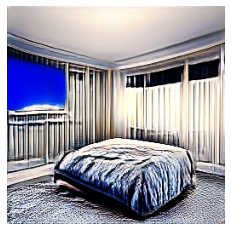

1701
Reg_Loss: 160896548864.000000
Loss : 0.386669
1702
Reg_Loss: 222184521728.000000
Loss : 0.367094
1703
Reg_Loss: 209850269696.000000
Loss : 0.377397
1704
Reg_Loss: 191639453696.000000
Loss : 0.381065
1705
Reg_Loss: 194832728064.000000
Loss : 0.359249
1706
Reg_Loss: 195215245312.000000
Loss : 0.398105
1707
Reg_Loss: 156774547456.000000
Loss : 0.416178
1708
Reg_Loss: 82438873088.000000
Loss : 0.429150
1709
Reg_Loss: 19867836416.000000
Loss : 0.398689
1710
Reg_Loss: 35049218048.000000
Loss : 0.367045
1711
Reg_Loss: 81856659456.000000
Loss : 0.377643
1712
Reg_Loss: 71538139136.000000
Loss : 0.358181
1713
Reg_Loss: 92444778496.000000
Loss : 0.372165
1714
Reg_Loss: 104382275584.000000
Loss : 0.395367
1715
Reg_Loss: 383838496.000000
Loss : 0.369987
1716
Reg_Loss: 29612613632.000000
Loss : 0.424353
1717
Reg_Loss: 23761266688.000000
Loss : 0.365489
1718
Reg_Loss: 18023925760.000000
Loss : 0.378214
1719
Reg_Loss: 3487106816.000000
Loss : 0.380070
1720
Reg_Loss: 63197978624.000000
Loss : 0.36

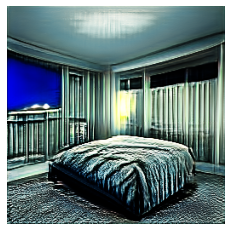

1801
Reg_Loss: 597199424.000000
Loss : 0.373735
1802
Reg_Loss: 126697488384.000000
Loss : 0.412766
1803
Reg_Loss: 110322540544.000000
Loss : 0.399410
1804
Reg_Loss: 31416797184.000000
Loss : 0.390572
1805
Reg_Loss: 52898283520.000000
Loss : 0.359529
1806
Reg_Loss: 2245796096.000000
Loss : 0.366643
1807
Reg_Loss: 15217130496.000000
Loss : 0.346958
1808
Reg_Loss: 448295424.000000
Loss : 0.355727
1809
Reg_Loss: 29377435648.000000
Loss : 0.359928
1810
Reg_Loss: 24383102976.000000
Loss : 0.360896
1811
Reg_Loss: 16839441408.000000
Loss : 0.368339
1812
Reg_Loss: 18064216064.000000
Loss : 0.378883
1813
Reg_Loss: 6459485184.000000
Loss : 0.361090
1814
Reg_Loss: 4821675520.000000
Loss : 0.341947
1815
Reg_Loss: 10514836480.000000
Loss : 0.376211
1816
Reg_Loss: 7980497408.000000
Loss : 0.374563
1817
Reg_Loss: 7191336960.000000
Loss : 0.378386
1818
Reg_Loss: 4307011584.000000
Loss : 0.384782
1819
Reg_Loss: 17101143040.000000
Loss : 0.404235
1820
Reg_Loss: 22844504064.000000
Loss : 0.396368
1821
Reg

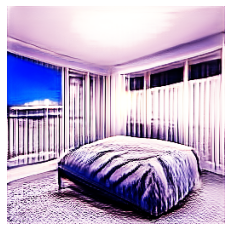

1901
Reg_Loss: 146518048768.000000
Loss : 0.361593
1902
Reg_Loss: 143501082624.000000
Loss : 0.364503
1903
Reg_Loss: 78204567552.000000
Loss : 0.370589
1904
Reg_Loss: 117524996096.000000
Loss : 0.354009
1905
Reg_Loss: 106493288448.000000
Loss : 0.349243
1906
Reg_Loss: 64213594112.000000
Loss : 0.366424
1907
Reg_Loss: 46205169664.000000
Loss : 0.327103
1908
Reg_Loss: 53467860992.000000
Loss : 0.352233
1909
Reg_Loss: 19661701120.000000
Loss : 0.354273
1910
Reg_Loss: 14986950656.000000
Loss : 0.360264
1911
Reg_Loss: 27030222848.000000
Loss : 0.395645
1912
Reg_Loss: 45490409472.000000
Loss : 0.351843
1913
Reg_Loss: 38388146176.000000
Loss : 0.366629
1914
Reg_Loss: 7450707456.000000
Loss : 0.350378
1915
Reg_Loss: 59992338432.000000
Loss : 0.396017
1916
Reg_Loss: 63589138432.000000
Loss : 0.344182
1917
Reg_Loss: 19690029056.000000
Loss : 0.332733
1918
Reg_Loss: 2713212160.000000
Loss : 0.333843
1919
Reg_Loss: 61575323648.000000
Loss : 0.346325
1920
Reg_Loss: 3936070656.000000
Loss : 0.350809

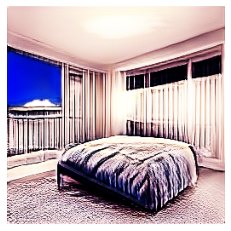

2001
Reg_Loss: 10504073216.000000
Loss : 0.394920
2002
Reg_Loss: 495707422720.000000
Loss : 0.327556
2003
Reg_Loss: 504325603328.000000
Loss : 0.339527
2004
Reg_Loss: 208241065984.000000
Loss : 0.335781
2005
Reg_Loss: 25482293248.000000
Loss : 0.345382
2006
Reg_Loss: 216560304128.000000
Loss : 0.348349
2007
Reg_Loss: 210741035008.000000
Loss : 0.406191
2008
Reg_Loss: 747462328320.000000
Loss : 0.354527
2009
Reg_Loss: 261853396992.000000
Loss : 0.339996
2010
Reg_Loss: 912750346240.000000
Loss : 0.336265
2011
Reg_Loss: 499223560192.000000
Loss : 0.343174
2012
Reg_Loss: 1638014779392.000000
Loss : 0.375900
2013
Reg_Loss: 1497002934272.000000
Loss : 0.371517
2014
Reg_Loss: 97897226240.000000
Loss : 0.328802
2015
Reg_Loss: 378836287488.000000
Loss : 0.353316
2016
Reg_Loss: 1243739979776.000000
Loss : 0.354314
2017
Reg_Loss: 610972467200.000000
Loss : 0.361901
2018
Reg_Loss: 205326221312.000000
Loss : 0.355397
2019
Reg_Loss: 127376883712.000000
Loss : 0.348852
2020
Reg_Loss: 404725170176.000

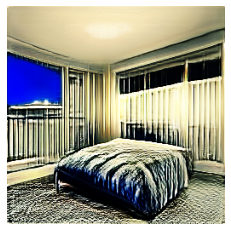

2101
Reg_Loss: 438128803840.000000
Loss : 0.350047
2102
Reg_Loss: 110437212160.000000
Loss : 0.396755
2103
Reg_Loss: 1114480312320.000000
Loss : 0.345534
2104
Reg_Loss: 1104125624320.000000
Loss : 0.357858
2105
Reg_Loss: 196553342976.000000
Loss : 0.325663
2106
Reg_Loss: 40733564928.000000
Loss : 0.316409
2107
Reg_Loss: 204380864512.000000
Loss : 0.354238
2108
Reg_Loss: 711173472256.000000
Loss : 0.355989
2109
Reg_Loss: 317990699008.000000
Loss : 0.347136
2110
Reg_Loss: 2644682473472.000000
Loss : 0.364704
2111
Reg_Loss: 1421108051968.000000
Loss : 0.370311
2112
Reg_Loss: 1203438485504.000000
Loss : 0.352264
2113
Reg_Loss: 980643217408.000000
Loss : 0.333167
2114
Reg_Loss: 1846766862336.000000
Loss : 0.336368
2115
Reg_Loss: 1850985807872.000000
Loss : 0.367775
2116
Reg_Loss: 879087452160.000000
Loss : 0.350322
2117
Reg_Loss: 1329776164864.000000
Loss : 0.361750
2118
Reg_Loss: 1075627098112.000000
Loss : 0.346321
2119
Reg_Loss: 502877356032.000000
Loss : 0.352757
2120
Reg_Loss: 66199650

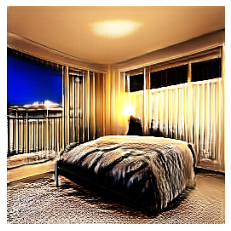

2201
Reg_Loss: 138571644928.000000
Loss : 0.322342
2202
Reg_Loss: 1460486012928.000000
Loss : 0.346428
2203
Reg_Loss: 1448269447168.000000
Loss : 0.410122
2204
Reg_Loss: 1589105262592.000000
Loss : 0.357389
2205
Reg_Loss: 1258723344384.000000
Loss : 0.374205
2206
Reg_Loss: 1505118650368.000000
Loss : 0.362833
2207
Reg_Loss: 1174930718720.000000
Loss : 0.358940
2208
Reg_Loss: 496015409152.000000
Loss : 0.356266
2209
Reg_Loss: 809263431680.000000
Loss : 0.311590
2210
Reg_Loss: 99880214528.000000
Loss : 0.314611
2211
Reg_Loss: 635100987392.000000
Loss : 0.358696
2212
Reg_Loss: 75583594496.000000
Loss : 0.334213
2213
Reg_Loss: 3626246078464.000000
Loss : 0.389057
2214
Reg_Loss: 2803387858944.000000
Loss : 0.361055
2215
Reg_Loss: 582609469440.000000
Loss : 0.377453
2216
Reg_Loss: 657029988352.000000
Loss : 0.353926
2217
Reg_Loss: 1022419730432.000000
Loss : 0.352500
2218
Reg_Loss: 1282944270336.000000
Loss : 0.349803
2219
Reg_Loss: 85389516800.000000
Loss : 0.335375
2220
Reg_Loss: 378783531

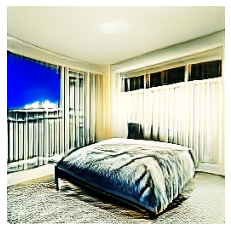

2301
Reg_Loss: 251079622656.000000
Loss : 0.362304
2302
Reg_Loss: 145354817536.000000
Loss : 0.310370
2303
Reg_Loss: 1551378284544.000000
Loss : 0.331067
2304
Reg_Loss: 1411838640128.000000
Loss : 0.362211
2305
Reg_Loss: 27353755648.000000
Loss : 0.301310
2306
Reg_Loss: 1153482883072.000000
Loss : 0.374636
2307
Reg_Loss: 622035664896.000000
Loss : 0.315504
2308
Reg_Loss: 542514380800.000000
Loss : 0.330559
2309
Reg_Loss: 4323990306816.000000
Loss : 0.358735
2310
Reg_Loss: 2207042240512.000000
Loss : 0.319822
2311
Reg_Loss: 2258960121856.000000
Loss : 0.325373
2312
Reg_Loss: 303957049344.000000
Loss : 0.379503
2313
Reg_Loss: 8801040203776.000000
Loss : 0.440154
2314
Reg_Loss: 7713370669056.000000
Loss : 0.430632
2315
Reg_Loss: 542425350144.000000
Loss : 0.303928
2316
Reg_Loss: 642919956480.000000
Loss : 0.358001
2317
Reg_Loss: 826621820928.000000
Loss : 0.307630
2318
Reg_Loss: 16493991428096.000000
Loss : 0.480297
2319
Reg_Loss: 12038592004096.000000
Loss : 0.471315
2320
Reg_Loss: 18460

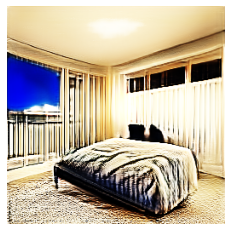

2401
Reg_Loss: 123650220032.000000
Loss : 0.335216
2402
Reg_Loss: 120798429184.000000
Loss : 0.323785
2403
Reg_Loss: 26315218944.000000
Loss : 0.367277
2404
Reg_Loss: 58791256064.000000
Loss : 0.330789
2405
Reg_Loss: 3393785088.000000
Loss : 0.303160
2406
Reg_Loss: 100101963776.000000
Loss : 0.313415
2407
Reg_Loss: 34659700736.000000
Loss : 0.302061
2408
Reg_Loss: 294460915712.000000
Loss : 0.342220
2409
Reg_Loss: 230838091776.000000
Loss : 0.319100
2410
Reg_Loss: 52664938496.000000
Loss : 0.316661
2411
Reg_Loss: 101872820224.000000
Loss : 0.355267
2412
Reg_Loss: 12172611584.000000
Loss : 0.314961
2413
Reg_Loss: 401878843392.000000
Loss : 0.379682
2414
Reg_Loss: 333100023808.000000
Loss : 0.341083
2415
Reg_Loss: 26424473600.000000
Loss : 0.336930
2416
Reg_Loss: 36894662656.000000
Loss : 0.334971
2417
Reg_Loss: 145117085696.000000
Loss : 0.358938
2418
Reg_Loss: 165963399168.000000
Loss : 0.321740
2419
Reg_Loss: 5234703872.000000
Loss : 0.334589
2420
Reg_Loss: 33607157760.000000
Loss : 0

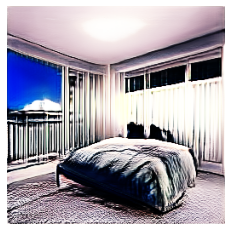

2501
Reg_Loss: 455642742784.000000
Loss : 0.347828
2502
Reg_Loss: 800085311488.000000
Loss : 0.367595
2503
Reg_Loss: 223446138880.000000
Loss : 0.330375
2504
Reg_Loss: 1573365088256.000000
Loss : 0.311710
2505
Reg_Loss: 833337753600.000000
Loss : 0.342719
2506
Reg_Loss: 526114226176.000000
Loss : 0.345439
2507
Reg_Loss: 15215667200.000000
Loss : 0.313817
2508
Reg_Loss: 858927202304.000000
Loss : 0.316630
2509
Reg_Loss: 2132714848256.000000
Loss : 0.333695
2510
Reg_Loss: 374883450880.000000
Loss : 0.319858
2511
Reg_Loss: 2391473127424.000000
Loss : 0.326033
2512
Reg_Loss: 309435039744.000000
Loss : 0.351671
2513
Reg_Loss: 699284717568.000000
Loss : 0.348218
2514
Reg_Loss: 261881757696.000000
Loss : 0.361417
2515
Reg_Loss: 64292319232.000000
Loss : 0.327409
2516
Reg_Loss: 277947318272.000000
Loss : 0.331141
2517
Reg_Loss: 308152008704.000000
Loss : 0.291528
2518
Reg_Loss: 115437068288.000000
Loss : 0.321756
2519
Reg_Loss: 9053172736.000000
Loss : 0.314243
2520
Reg_Loss: 33276858368.00000

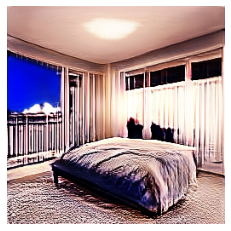

2601
Reg_Loss: 177494835200.000000
Loss : 0.310798
2602
Reg_Loss: 263008845824.000000
Loss : 0.297457
2603
Reg_Loss: 275546112000.000000
Loss : 0.305357
2604
Reg_Loss: 307379535872.000000
Loss : 0.298304
2605
Reg_Loss: 239123677184.000000
Loss : 0.320952
2606
Reg_Loss: 309747613696.000000
Loss : 0.326706
2607
Reg_Loss: 212497481728.000000
Loss : 0.318764
2608
Reg_Loss: 59712172032.000000
Loss : 0.299104
2609
Reg_Loss: 2549122816.000000
Loss : 0.319607
2610
Reg_Loss: 355402612736.000000
Loss : 0.301008
2611
Reg_Loss: 327372996608.000000
Loss : 0.285137
2612
Reg_Loss: 15144037376.000000
Loss : 0.290945
2613
Reg_Loss: 46057181184.000000
Loss : 0.306111
2614
Reg_Loss: 100962820096.000000
Loss : 0.296233
2615
Reg_Loss: 104859344896.000000
Loss : 0.283461
2616
Reg_Loss: 36714532864.000000
Loss : 0.307945
2617
Reg_Loss: 218539474944.000000
Loss : 0.340461
2618
Reg_Loss: 180347305984.000000
Loss : 0.300456
2619
Reg_Loss: 29408436224.000000
Loss : 0.281356
2620
Reg_Loss: 34273380352.000000
Loss

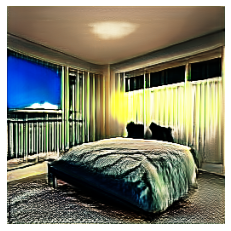

2701
Reg_Loss: 859117453312.000000
Loss : 0.300446
2702
Reg_Loss: 448777748480.000000
Loss : 0.294545
2703
Reg_Loss: 589054279680.000000
Loss : 0.344734
2704
Reg_Loss: 269298679808.000000
Loss : 0.307199
2705
Reg_Loss: 1972400029696.000000
Loss : 0.300177
2706
Reg_Loss: 1532623323136.000000
Loss : 0.352457
2707
Reg_Loss: 291830726656.000000
Loss : 0.298629
2708
Reg_Loss: 169083518976.000000
Loss : 0.307367
2709
Reg_Loss: 1785342853120.000000
Loss : 0.308002
2710
Reg_Loss: 1532290662400.000000
Loss : 0.318337
2711
Reg_Loss: 325644713984.000000
Loss : 0.297302
2712
Reg_Loss: 351528910848.000000
Loss : 0.283772
2713
Reg_Loss: 765348282368.000000
Loss : 0.345318
2714
Reg_Loss: 701269868544.000000
Loss : 0.285283
2715
Reg_Loss: 250077806592.000000
Loss : 0.306600
2716
Reg_Loss: 285973839872.000000
Loss : 0.328129
2717
Reg_Loss: 227628204032.000000
Loss : 0.315085
2718
Reg_Loss: 196178608128.000000
Loss : 0.321845
2719
Reg_Loss: 280341282816.000000
Loss : 0.343892
2720
Reg_Loss: 289098465280

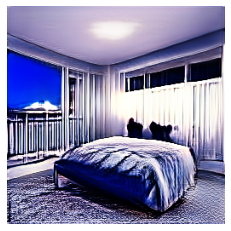

2801
Reg_Loss: 709443780608.000000
Loss : 0.331746
2802
Reg_Loss: 297416556544.000000
Loss : 0.283934
2803
Reg_Loss: 524088639488.000000
Loss : 0.289769
2804
Reg_Loss: 140238045184.000000
Loss : 0.296143
2805
Reg_Loss: 2443486167040.000000
Loss : 0.315727
2806
Reg_Loss: 829165273088.000000
Loss : 0.287478
2807
Reg_Loss: 1352009383936.000000
Loss : 0.360090
2808
Reg_Loss: 543778209792.000000
Loss : 0.310254
2809
Reg_Loss: 755244859392.000000
Loss : 0.300981
2810
Reg_Loss: 3069534535680.000000
Loss : 0.314949
2811
Reg_Loss: 2884656693248.000000
Loss : 0.306722
2812
Reg_Loss: 1175374659584.000000
Loss : 0.317718
2813
Reg_Loss: 640548536320.000000
Loss : 0.286008
2814
Reg_Loss: 595610828800.000000
Loss : 0.301238
2815
Reg_Loss: 4425016410112.000000
Loss : 0.352134
2816
Reg_Loss: 1842446073856.000000
Loss : 0.343442
2817
Reg_Loss: 10892451250176.000000
Loss : 0.422476
2818
Reg_Loss: 6694505021440.000000
Loss : 0.355356
2819
Reg_Loss: 237395066880.000000
Loss : 0.292020
2820
Reg_Loss: 335407

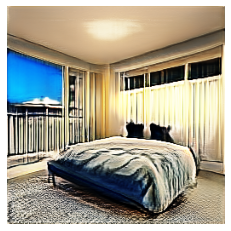

2901
Reg_Loss: 15269676187648.000000
Loss : 0.448699
2902
Reg_Loss: 69795189882880.000000
Loss : 0.974338
2903
Reg_Loss: 73562345963520.000000
Loss : 1.017762
2904
Reg_Loss: 12756292993024.000000
Loss : 0.427496
2905
Reg_Loss: 87245222576128.000000
Loss : 1.168639
2906
Reg_Loss: 93003389599744.000000
Loss : 1.233347
2907
Reg_Loss: 35325141319680.000000
Loss : 0.636428
2908
Reg_Loss: 23444292894720.000000
Loss : 0.522572
2909
Reg_Loss: 32709260869632.000000
Loss : 0.609156
2910
Reg_Loss: 15281390878720.000000
Loss : 0.462169
2911
Reg_Loss: 29160988737536.000000
Loss : 0.575657
2912
Reg_Loss: 33311177048064.000000
Loss : 0.654468
2913
Reg_Loss: 12792457330688.000000
Loss : 0.432726
2914
Reg_Loss: 107064986697728.000000
Loss : 1.388788
2915
Reg_Loss: 100550284673024.000000
Loss : 1.304278
2916
Reg_Loss: 1194236968960.000000
Loss : 0.290394
2917
Reg_Loss: 7490814607360.000000
Loss : 0.348806
2918
Reg_Loss: 39052162105344.000000
Loss : 0.663372
2919
Reg_Loss: 26652587327488.000000
Loss : 0.

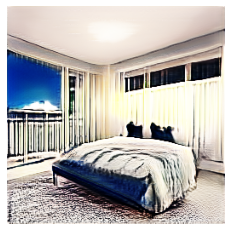

3001
Reg_Loss: 73578209280.000000
Loss : 0.258394
3002
Reg_Loss: 10363938537472.000000
Loss : 0.367203
3003
Reg_Loss: 13972583481344.000000
Loss : 0.413128
3004
Reg_Loss: 5072187031552.000000
Loss : 0.311357
3005
Reg_Loss: 13771127914496.000000
Loss : 0.451192
3006
Reg_Loss: 19435880448000.000000
Loss : 0.493394
3007
Reg_Loss: 14651379154944.000000
Loss : 0.434141
3008
Reg_Loss: 5285709086720.000000
Loss : 0.320035
3009
Reg_Loss: 2392169906176.000000
Loss : 0.319999
3010
Reg_Loss: 2720039436288.000000
Loss : 0.287282
3011
Reg_Loss: 2024456585216.000000
Loss : 0.292613
3012
Reg_Loss: 6216902246400.000000
Loss : 0.380549
3013
Reg_Loss: 7152214736896.000000
Loss : 0.388422
3014
Reg_Loss: 3801092194304.000000
Loss : 0.319364
3015
Reg_Loss: 3313613930496.000000
Loss : 0.316433
3016
Reg_Loss: 5150739529728.000000
Loss : 0.304421
3017
Reg_Loss: 2769659101184.000000
Loss : 0.290663
3018
Reg_Loss: 778521280512.000000
Loss : 0.279129
3019
Reg_Loss: 1303166320640.000000
Loss : 0.285353
3020
Reg_L

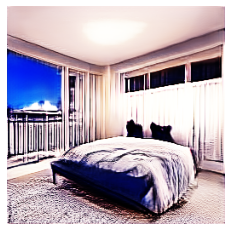

3101
Reg_Loss: 24073680896.000000
Loss : 0.276840
3102
Reg_Loss: 19885887488.000000
Loss : 0.261460
3103
Reg_Loss: 33387171840.000000
Loss : 0.267366
3104
Reg_Loss: 12327688192.000000
Loss : 0.273630
3105
Reg_Loss: 28612370432.000000
Loss : 0.265003
3106
Reg_Loss: 38124433408.000000
Loss : 0.275565
3107
Reg_Loss: 28707983360.000000
Loss : 0.308946
3108
Reg_Loss: 3265625600.000000
Loss : 0.293679
3109
Reg_Loss: 37861236736.000000
Loss : 0.267911
3110
Reg_Loss: 60673683456.000000
Loss : 0.253481
3111
Reg_Loss: 62680150016.000000
Loss : 0.245423
3112
Reg_Loss: 47245373440.000000
Loss : 0.311392
3113
Reg_Loss: 21685008384.000000
Loss : 0.273271
3114
Reg_Loss: 11434431488.000000
Loss : 0.321050
3115
Reg_Loss: 18751551488.000000
Loss : 0.266804
3116
Reg_Loss: 6999779840.000000
Loss : 0.260324
3117
Reg_Loss: 3222216704.000000
Loss : 0.261281
3118
Reg_Loss: 42913427456.000000
Loss : 0.290517
3119
Reg_Loss: 51371528192.000000
Loss : 0.287444
3120
Reg_Loss: 18255212544.000000
Loss : 0.279623
312

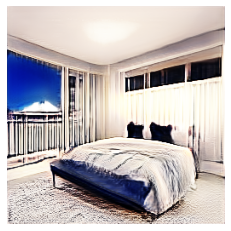

3201
Reg_Loss: 55255355392.000000
Loss : 0.275080
3202
Reg_Loss: 42828558336.000000
Loss : 0.257429
3203
Reg_Loss: 11025601536.000000
Loss : 0.309209
3204
Reg_Loss: 28999794688.000000
Loss : 0.280071
3205
Reg_Loss: 40505774080.000000
Loss : 0.250548
3206
Reg_Loss: 15868106752.000000
Loss : 0.262995
3207
Reg_Loss: 69649940480.000000
Loss : 0.254981
3208
Reg_Loss: 82266701824.000000
Loss : 0.274278
3209
Reg_Loss: 12555796480.000000
Loss : 0.280471
3210
Reg_Loss: 74480648192.000000
Loss : 0.257155
3211
Reg_Loss: 95673155584.000000
Loss : 0.294114
3212
Reg_Loss: 78015709184.000000
Loss : 0.268779
3213
Reg_Loss: 10731941888.000000
Loss : 0.269392
3214
Reg_Loss: 152383782912.000000
Loss : 0.269566
3215
Reg_Loss: 204204883968.000000
Loss : 0.266816
3216
Reg_Loss: 110596808704.000000
Loss : 0.264456
3217
Reg_Loss: 16348388352.000000
Loss : 0.274588
3218
Reg_Loss: 37361385472.000000
Loss : 0.252264
3219
Reg_Loss: 5890238464.000000
Loss : 0.283496
3220
Reg_Loss: 79559811072.000000
Loss : 0.29386

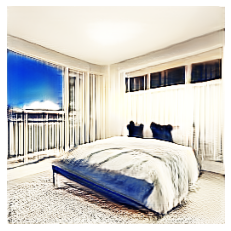

3301
Reg_Loss: 4185779200.000000
Loss : 0.262679
3302
Reg_Loss: 2113743616.000000
Loss : 0.295381
3303
Reg_Loss: 12512082944.000000
Loss : 0.263424
3304
Reg_Loss: 9073484800.000000
Loss : 0.266118
3305
Reg_Loss: 9091910656.000000
Loss : 0.275308
3306
Reg_Loss: 5429010944.000000
Loss : 0.265926
3307
Reg_Loss: 16809525248.000000
Loss : 0.272974
3308
Reg_Loss: 15834938368.000000
Loss : 0.298485
3309
Reg_Loss: 7593724928.000000
Loss : 0.285588
3310
Reg_Loss: 8184697856.000000
Loss : 0.261761
3311
Reg_Loss: 10566727680.000000
Loss : 0.274076
3312
Reg_Loss: 4660876288.000000
Loss : 0.272100
3313
Reg_Loss: 20398409728.000000
Loss : 0.281175
3314
Reg_Loss: 23956742144.000000
Loss : 0.286173
3315
Reg_Loss: 6767982592.000000
Loss : 0.308897
3316
Reg_Loss: 28322291712.000000
Loss : 0.281414
3317
Reg_Loss: 42624999424.000000
Loss : 0.270119
3318
Reg_Loss: 37034090496.000000
Loss : 0.263979
3319
Reg_Loss: 9354657792.000000
Loss : 0.286851
3320
Reg_Loss: 42062356480.000000
Loss : 0.272309
3321
Reg_L

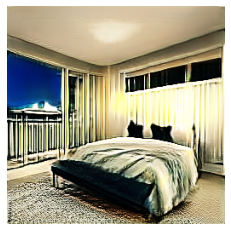

3401
Reg_Loss: 69700370432.000000
Loss : 0.271180
3402
Reg_Loss: 141063913472.000000
Loss : 0.248032
3403
Reg_Loss: 49203138560.000000
Loss : 0.263092
3404
Reg_Loss: 310683762688.000000
Loss : 0.242634
3405
Reg_Loss: 333088620544.000000
Loss : 0.243134
3406
Reg_Loss: 149935128576.000000
Loss : 0.246260
3407
Reg_Loss: 55538085888.000000
Loss : 0.247629
3408
Reg_Loss: 11577288704.000000
Loss : 0.279133
3409
Reg_Loss: 28571598848.000000
Loss : 0.244018
3410
Reg_Loss: 277040594944.000000
Loss : 0.264997
3411
Reg_Loss: 181046755328.000000
Loss : 0.289295
3412
Reg_Loss: 360835973120.000000
Loss : 0.258234
3413
Reg_Loss: 386330034176.000000
Loss : 0.307499
3414
Reg_Loss: 34448244736.000000
Loss : 0.261791
3415
Reg_Loss: 503504306176.000000
Loss : 0.263194
3416
Reg_Loss: 497469587456.000000
Loss : 0.253976
3417
Reg_Loss: 89159745536.000000
Loss : 0.245505
3418
Reg_Loss: 451117678592.000000
Loss : 0.291115
3419
Reg_Loss: 535045701632.000000
Loss : 0.288302
3420
Reg_Loss: 34502860800.000000
Loss

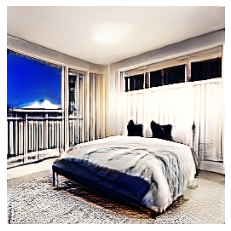

3501
Reg_Loss: 267992203264.000000
Loss : 0.294996
3502
Reg_Loss: 86470221824.000000
Loss : 0.260829
3503
Reg_Loss: 65837244416.000000
Loss : 0.239831
3504
Reg_Loss: 328293941248.000000
Loss : 0.284756
3505
Reg_Loss: 178392956928.000000
Loss : 0.270293
3506
Reg_Loss: 437880782848.000000
Loss : 0.245923
3507
Reg_Loss: 380992454656.000000
Loss : 0.261452
3508
Reg_Loss: 35818131456.000000
Loss : 0.251260
3509
Reg_Loss: 107974443008.000000
Loss : 0.242124
3510
Reg_Loss: 93363126272.000000
Loss : 0.229468
3511
Reg_Loss: 60230766592.000000
Loss : 0.242553
3512
Reg_Loss: 4434339328.000000
Loss : 0.275030
3513
Reg_Loss: 23195275264.000000
Loss : 0.271696
3514
Reg_Loss: 32041211904.000000
Loss : 0.271706
3515
Reg_Loss: 43386753024.000000
Loss : 0.237906
3516
Reg_Loss: 30377979904.000000
Loss : 0.238740
3517
Reg_Loss: 57189441536.000000
Loss : 0.253307
3518
Reg_Loss: 36016668672.000000
Loss : 0.248032
3519
Reg_Loss: 30964858880.000000
Loss : 0.235654
3520
Reg_Loss: 69352087552.000000
Loss : 0.23

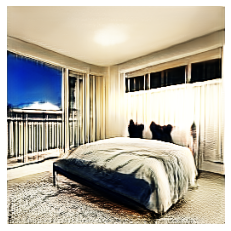

3601
Reg_Loss: 54051110912.000000
Loss : 0.292592
3602
Reg_Loss: 4361482752.000000
Loss : 0.268005
3603
Reg_Loss: 60640550912.000000
Loss : 0.261882
3604
Reg_Loss: 84453933056.000000
Loss : 0.281876
3605
Reg_Loss: 38836146176.000000
Loss : 0.240834
3606
Reg_Loss: 160825868288.000000
Loss : 0.268827
3607
Reg_Loss: 157149233152.000000
Loss : 0.297469
3608
Reg_Loss: 52930371584.000000
Loss : 0.307686
3609
Reg_Loss: 95937609728.000000
Loss : 0.271347
3610
Reg_Loss: 58232430592.000000
Loss : 0.325416
3611
Reg_Loss: 77383704576.000000
Loss : 0.280253
3612
Reg_Loss: 52899508224.000000
Loss : 0.270258
3613
Reg_Loss: 56648265728.000000
Loss : 0.259773
3614
Reg_Loss: 65526837248.000000
Loss : 0.254804
3615
Reg_Loss: 35399905280.000000
Loss : 0.266620
3616
Reg_Loss: 20246814720.000000
Loss : 0.288269
3617
Reg_Loss: 43459502080.000000
Loss : 0.253141
3618
Reg_Loss: 36405698560.000000
Loss : 0.259294
3619
Reg_Loss: 4269846528.000000
Loss : 0.241548
3620
Reg_Loss: 48526540800.000000
Loss : 0.236985


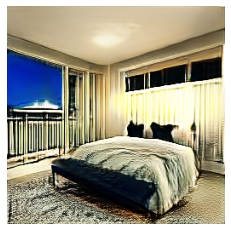

3701
Reg_Loss: 82866192384.000000
Loss : 0.240327
3702
Reg_Loss: 15952428032.000000
Loss : 0.269076
3703
Reg_Loss: 110962745344.000000
Loss : 0.242412
3704
Reg_Loss: 157977346048.000000
Loss : 0.234027
3705
Reg_Loss: 122712137728.000000
Loss : 0.238845
3706
Reg_Loss: 67642413056.000000
Loss : 0.224204
3707
Reg_Loss: 33362108416.000000
Loss : 0.229405
3708
Reg_Loss: 6133833216.000000
Loss : 0.221529
3709
Reg_Loss: 64286109696.000000
Loss : 0.237361
3710
Reg_Loss: 10765770752.000000
Loss : 0.239900
3711
Reg_Loss: 190523146240.000000
Loss : 0.221186
3712
Reg_Loss: 225070956544.000000
Loss : 0.265380
3713
Reg_Loss: 147243614208.000000
Loss : 0.249784
3714
Reg_Loss: 25643085824.000000
Loss : 0.229814
3715
Reg_Loss: 45907550208.000000
Loss : 0.236513
3716
Reg_Loss: 123592556544.000000
Loss : 0.232712
3717
Reg_Loss: 113836752896.000000
Loss : 0.230814
3718
Reg_Loss: 89574187008.000000
Loss : 0.234683
3719
Reg_Loss: 218065174528.000000
Loss : 0.246325
3720
Reg_Loss: 21674637312.000000
Loss : 0

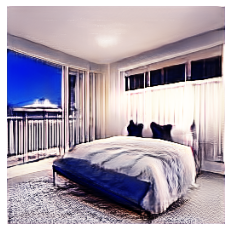

3801
Reg_Loss: 347281817600.000000
Loss : 0.262876
3802
Reg_Loss: 157611327488.000000
Loss : 0.256488
3803
Reg_Loss: 273622990848.000000
Loss : 0.247856
3804
Reg_Loss: 349655760896.000000
Loss : 0.272772
3805
Reg_Loss: 34957094912.000000
Loss : 0.250482
3806
Reg_Loss: 272274522112.000000
Loss : 0.266093
3807
Reg_Loss: 116206608384.000000
Loss : 0.282801
3808
Reg_Loss: 761416581120.000000
Loss : 0.276074
3809
Reg_Loss: 883405619200.000000
Loss : 0.280309
3810
Reg_Loss: 146441961472.000000
Loss : 0.268519
3811
Reg_Loss: 502015262720.000000
Loss : 0.272634
3812
Reg_Loss: 170128326656.000000
Loss : 0.242497
3813
Reg_Loss: 1555333513216.000000
Loss : 0.254791
3814
Reg_Loss: 1787771748352.000000
Loss : 0.281307
3815
Reg_Loss: 364429901824.000000
Loss : 0.256485
3816
Reg_Loss: 596491960320.000000
Loss : 0.250497
3817
Reg_Loss: 133955764224.000000
Loss : 0.236072
3818
Reg_Loss: 640032178176.000000
Loss : 0.243436
3819
Reg_Loss: 492718424064.000000
Loss : 0.268784
3820
Reg_Loss: 9413175296.0000

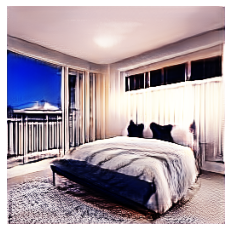

3901
Reg_Loss: 118332186624.000000
Loss : 0.249913
3902
Reg_Loss: 25643816960.000000
Loss : 0.239379
3903
Reg_Loss: 243433193472.000000
Loss : 0.237467
3904
Reg_Loss: 293623824384.000000
Loss : 0.250824
3905
Reg_Loss: 255928500224.000000
Loss : 0.238219
3906
Reg_Loss: 135430242304.000000
Loss : 0.232619
3907
Reg_Loss: 184995741696.000000
Loss : 0.238638
3908
Reg_Loss: 217493733376.000000
Loss : 0.250457
3909
Reg_Loss: 40872202240.000000
Loss : 0.275934
3910
Reg_Loss: 67131080704.000000
Loss : 0.229908
3911
Reg_Loss: 7079105536.000000
Loss : 0.224010
3912
Reg_Loss: 326832384.000000
Loss : 0.220130
3913
Reg_Loss: 51188142080.000000
Loss : 0.267838
3914
Reg_Loss: 65415696384.000000
Loss : 0.231695
3915
Reg_Loss: 56896282624.000000
Loss : 0.231819
3916
Reg_Loss: 19530735616.000000
Loss : 0.223110
3917
Reg_Loss: 61540782080.000000
Loss : 0.247338
3918
Reg_Loss: 86626320384.000000
Loss : 0.236330
3919
Reg_Loss: 55393755136.000000
Loss : 0.245916
3920
Reg_Loss: 35902160896.000000
Loss : 0.243

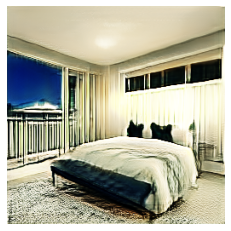

4001
Reg_Loss: 45434138624.000000
Loss : 0.240300
4002
Reg_Loss: 9329814528.000000
Loss : 0.226826
4003
Reg_Loss: 89324814336.000000
Loss : 0.259287
4004
Reg_Loss: 1009722496.000000
Loss : 0.227768
4005
Reg_Loss: 168184889344.000000
Loss : 0.228668
4006
Reg_Loss: 191984254976.000000
Loss : 0.222185
4007
Reg_Loss: 136105828352.000000
Loss : 0.228154
4008
Reg_Loss: 3063441408.000000
Loss : 0.217122
4009
Reg_Loss: 322369028096.000000
Loss : 0.221056
4010
Reg_Loss: 340457357312.000000
Loss : 0.233936
4011
Reg_Loss: 5502210560.000000
Loss : 0.236900
4012
Reg_Loss: 2407828480.000000
Loss : 0.232471
4013
Reg_Loss: 248486854656.000000
Loss : 0.237541
4014
Reg_Loss: 107424948224.000000
Loss : 0.252176
4015
Reg_Loss: 122229096448.000000
Loss : 0.241034
4016
Reg_Loss: 135115800576.000000
Loss : 0.254269
4017
Reg_Loss: 50840145920.000000
Loss : 0.233958
4018
Reg_Loss: 54381285376.000000
Loss : 0.233850
4019
Reg_Loss: 221654515712.000000
Loss : 0.244064
4020
Reg_Loss: 253395451904.000000
Loss : 0.2

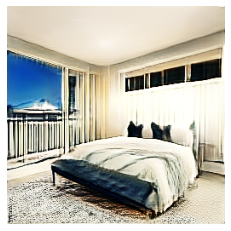

4101
Reg_Loss: 225013497856.000000
Loss : 0.224250
4102
Reg_Loss: 144181313536.000000
Loss : 0.265936
4103
Reg_Loss: 387572465664.000000
Loss : 0.273245
4104
Reg_Loss: 386509832192.000000
Loss : 0.239848
4105
Reg_Loss: 118682812416.000000
Loss : 0.265825
4106
Reg_Loss: 63853998080.000000
Loss : 0.249285
4107
Reg_Loss: 163882795008.000000
Loss : 0.222337
4108
Reg_Loss: 241651007488.000000
Loss : 0.224885
4109
Reg_Loss: 181685436416.000000
Loss : 0.242804
4110
Reg_Loss: 23805716480.000000
Loss : 0.232811
4111
Reg_Loss: 413577543680.000000
Loss : 0.211708
4112
Reg_Loss: 120948359168.000000
Loss : 0.222507
4113
Reg_Loss: 522024091648.000000
Loss : 0.231723
4114
Reg_Loss: 296567144448.000000
Loss : 0.232382
4115
Reg_Loss: 674213527552.000000
Loss : 0.215889
4116
Reg_Loss: 838062309376.000000
Loss : 0.227243
4117
Reg_Loss: 348837150720.000000
Loss : 0.209581
4118
Reg_Loss: 154247970816.000000
Loss : 0.240685
4119
Reg_Loss: 417981104128.000000
Loss : 0.277192
4120
Reg_Loss: 439434018816.00000

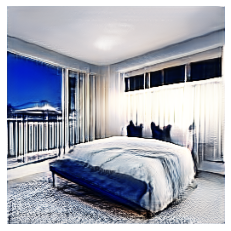

4201
Reg_Loss: 403167051776.000000
Loss : 0.243592
4202
Reg_Loss: 91338915840.000000
Loss : 0.240083
4203
Reg_Loss: 392670052352.000000
Loss : 0.229113
4204
Reg_Loss: 335435726848.000000
Loss : 0.224722
4205
Reg_Loss: 95743246336.000000
Loss : 0.227924
4206
Reg_Loss: 1256001896448.000000
Loss : 0.272576
4207
Reg_Loss: 682257874944.000000
Loss : 0.231537
4208
Reg_Loss: 574903091200.000000
Loss : 0.246850
4209
Reg_Loss: 539890974720.000000
Loss : 0.223773
4210
Reg_Loss: 562698911744.000000
Loss : 0.233572
4211
Reg_Loss: 754383060992.000000
Loss : 0.247986
4212
Reg_Loss: 197770854400.000000
Loss : 0.215023
4213
Reg_Loss: 287354748928.000000
Loss : 0.227647
4214
Reg_Loss: 23012765696.000000
Loss : 0.239679
4215
Reg_Loss: 622463614976.000000
Loss : 0.230408
4216
Reg_Loss: 454570606592.000000
Loss : 0.235306
4217
Reg_Loss: 120780161024.000000
Loss : 0.220052
4218
Reg_Loss: 99790127104.000000
Loss : 0.221182
4219
Reg_Loss: 378544652288.000000
Loss : 0.233709
4220
Reg_Loss: 504611471360.000000

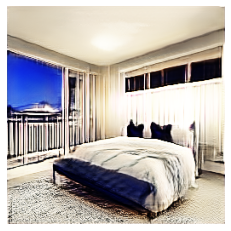

4301
Reg_Loss: 504443666432.000000
Loss : 0.260675
4302
Reg_Loss: 2516399423488.000000
Loss : 0.269761
4303
Reg_Loss: 2500522147840.000000
Loss : 0.306187
4304
Reg_Loss: 1344065634304.000000
Loss : 0.269918
4305
Reg_Loss: 3995419541504.000000
Loss : 0.259002
4306
Reg_Loss: 800634765312.000000
Loss : 0.218014
4307
Reg_Loss: 7479854366720.000000
Loss : 0.288997
4308
Reg_Loss: 4887877255168.000000
Loss : 0.289025
4309
Reg_Loss: 1737436823552.000000
Loss : 0.258504
4310
Reg_Loss: 2719283937280.000000
Loss : 0.244362
4311
Reg_Loss: 2468530356224.000000
Loss : 0.249629
4312
Reg_Loss: 2798141046784.000000
Loss : 0.239830
4313
Reg_Loss: 3814874677248.000000
Loss : 0.252758
4314
Reg_Loss: 3424056508416.000000
Loss : 0.242557
4315
Reg_Loss: 421540790272.000000
Loss : 0.239136
4316
Reg_Loss: 286808211456.000000
Loss : 0.237085
4317
Reg_Loss: 323895164928.000000
Loss : 0.207028
4318
Reg_Loss: 241218043904.000000
Loss : 0.228274
4319
Reg_Loss: 491969871872.000000
Loss : 0.225240
4320
Reg_Loss: 7730

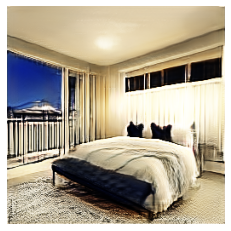

4401
Reg_Loss: 50579423232.000000
Loss : 0.225666
4402
Reg_Loss: 216098750464.000000
Loss : 0.205528
4403
Reg_Loss: 207397126144.000000
Loss : 0.232306
4404
Reg_Loss: 33016717312.000000
Loss : 0.228955
4405
Reg_Loss: 88479678464.000000
Loss : 0.214053
4406
Reg_Loss: 83334545408.000000
Loss : 0.214639
4407
Reg_Loss: 89900630016.000000
Loss : 0.219669
4408
Reg_Loss: 22099437568.000000
Loss : 0.218307
4409
Reg_Loss: 136432869376.000000
Loss : 0.235187
4410
Reg_Loss: 93689323520.000000
Loss : 0.226853
4411
Reg_Loss: 81928544256.000000
Loss : 0.221346
4412
Reg_Loss: 44023980032.000000
Loss : 0.214185
4413
Reg_Loss: 171269455872.000000
Loss : 0.244307
4414
Reg_Loss: 222434197504.000000
Loss : 0.212301
4415
Reg_Loss: 149320810496.000000
Loss : 0.215678
4416
Reg_Loss: 72493498368.000000
Loss : 0.223246
4417
Reg_Loss: 39046176768.000000
Loss : 0.214855
4418
Reg_Loss: 63875444736.000000
Loss : 0.222804
4419
Reg_Loss: 123671691264.000000
Loss : 0.215597
4420
Reg_Loss: 67093499904.000000
Loss : 0.

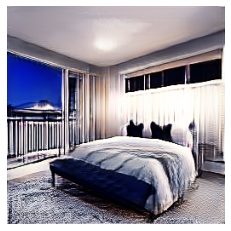

4501
Reg_Loss: 5797757059072.000000
Loss : 0.268015
4502
Reg_Loss: 7293066280960.000000
Loss : 0.318868
4503
Reg_Loss: 1204741210112.000000
Loss : 0.227544
4504
Reg_Loss: 1354364485632.000000
Loss : 0.221888
4505
Reg_Loss: 4783801368576.000000
Loss : 0.310687
4506
Reg_Loss: 2461023862784.000000
Loss : 0.292165
4507
Reg_Loss: 3170387886080.000000
Loss : 0.274583
4508
Reg_Loss: 4468504526848.000000
Loss : 0.256078
4509
Reg_Loss: 4280383700992.000000
Loss : 0.270417
4510
Reg_Loss: 3212002721792.000000
Loss : 0.250696
4511
Reg_Loss: 775569997824.000000
Loss : 0.231015
4512
Reg_Loss: 5881689800704.000000
Loss : 0.301086
4513
Reg_Loss: 6303125602304.000000
Loss : 0.276506
4514
Reg_Loss: 289835450368.000000
Loss : 0.236491
4515
Reg_Loss: 972965871616.000000
Loss : 0.215354
4516
Reg_Loss: 1864467349504.000000
Loss : 0.220144
4517
Reg_Loss: 225694875648.000000
Loss : 0.246017
4518
Reg_Loss: 2784349650944.000000
Loss : 0.286405
4519
Reg_Loss: 3539196444672.000000
Loss : 0.268942
4520
Reg_Loss: 3

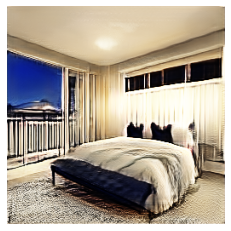

4601
Reg_Loss: 197155323904.000000
Loss : 0.220798
4602
Reg_Loss: 16220844032.000000
Loss : 0.190183
4603
Reg_Loss: 295216709632.000000
Loss : 0.203066
4604
Reg_Loss: 320508198912.000000
Loss : 0.196533
4605
Reg_Loss: 395124244480.000000
Loss : 0.191577
4606
Reg_Loss: 638959812608.000000
Loss : 0.205152
4607
Reg_Loss: 556409487360.000000
Loss : 0.208854
4608
Reg_Loss: 278780706816.000000
Loss : 0.232392
4609
Reg_Loss: 772982636544.000000
Loss : 0.204673
4610
Reg_Loss: 348702146560.000000
Loss : 0.210127
4611
Reg_Loss: 746204954624.000000
Loss : 0.201692
4612
Reg_Loss: 355724034048.000000
Loss : 0.218076
4613
Reg_Loss: 555884740608.000000
Loss : 0.194522
4614
Reg_Loss: 682394910720.000000
Loss : 0.242569
4615
Reg_Loss: 235363287040.000000
Loss : 0.205410
4616
Reg_Loss: 202486677504.000000
Loss : 0.191899
4617
Reg_Loss: 1062940114944.000000
Loss : 0.201331
4618
Reg_Loss: 1044693450752.000000
Loss : 0.240369
4619
Reg_Loss: 381640704000.000000
Loss : 0.190145
4620
Reg_Loss: 144498475008.00

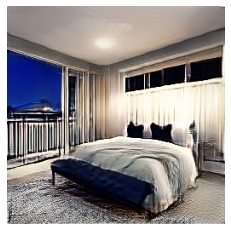

4701
Reg_Loss: 667631943680.000000
Loss : 0.231358
4702
Reg_Loss: 740965679104.000000
Loss : 0.194569
4703
Reg_Loss: 726046081024.000000
Loss : 0.193259
4704
Reg_Loss: 645212471296.000000
Loss : 0.225415
4705
Reg_Loss: 459608883200.000000
Loss : 0.219883
4706
Reg_Loss: 30991794176.000000
Loss : 0.203315
4707
Reg_Loss: 1112893030400.000000
Loss : 0.207473
4708
Reg_Loss: 1192314404864.000000
Loss : 0.207064
4709
Reg_Loss: 254515281920.000000
Loss : 0.205108
4710
Reg_Loss: 518043729920.000000
Loss : 0.192268
4711
Reg_Loss: 132816297984.000000
Loss : 0.195792
4712
Reg_Loss: 1552213475328.000000
Loss : 0.215797
4713
Reg_Loss: 2094513127424.000000
Loss : 0.238193
4714
Reg_Loss: 941170229248.000000
Loss : 0.201643
4715
Reg_Loss: 368486776832.000000
Loss : 0.192735
4716
Reg_Loss: 403877101568.000000
Loss : 0.208642
4717
Reg_Loss: 528727638016.000000
Loss : 0.212139
4718
Reg_Loss: 1007456288768.000000
Loss : 0.208570
4719
Reg_Loss: 429945257984.000000
Loss : 0.193725
4720
Reg_Loss: 423991279616

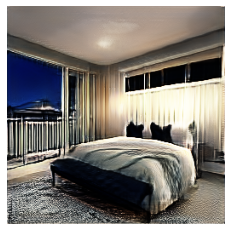

4801
Reg_Loss: 6812469760.000000
Loss : 0.199162
4802
Reg_Loss: 91439529984.000000
Loss : 0.197732
4803
Reg_Loss: 3194970624.000000
Loss : 0.188258
4804
Reg_Loss: 50356772864.000000
Loss : 0.203472
4805
Reg_Loss: 17869459456.000000
Loss : 0.203761
4806
Reg_Loss: 30636146688.000000
Loss : 0.192624
4807
Reg_Loss: 2356192000.000000
Loss : 0.216077
4808
Reg_Loss: 117427044352.000000
Loss : 0.227880
4809
Reg_Loss: 56906235904.000000
Loss : 0.185013
4810
Reg_Loss: 211252854784.000000
Loss : 0.188252
4811
Reg_Loss: 198048382976.000000
Loss : 0.210073
4812
Reg_Loss: 36851507200.000000
Loss : 0.207974
4813
Reg_Loss: 8949556224.000000
Loss : 0.193304
4814
Reg_Loss: 284398714880.000000
Loss : 0.185187
4815
Reg_Loss: 218376617984.000000
Loss : 0.195119
4816
Reg_Loss: 216449859584.000000
Loss : 0.185944
4817
Reg_Loss: 326709051392.000000
Loss : 0.186511
4818
Reg_Loss: 308237697024.000000
Loss : 0.195115
4819
Reg_Loss: 196740317184.000000
Loss : 0.210845
4820
Reg_Loss: 60784881664.000000
Loss : 0.18

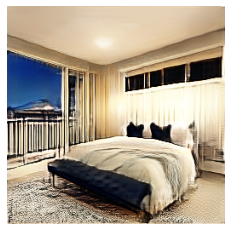

4901
Reg_Loss: 169673293824.000000
Loss : 0.187354
4902
Reg_Loss: 38472929280.000000
Loss : 0.184577
4903
Reg_Loss: 8333277184.000000
Loss : 0.184551
4904
Reg_Loss: 256166903808.000000
Loss : 0.185390
4905
Reg_Loss: 258450571264.000000
Loss : 0.192464
4906
Reg_Loss: 22091941888.000000
Loss : 0.196208
4907
Reg_Loss: 121619062784.000000
Loss : 0.184385
4908
Reg_Loss: 223469584384.000000
Loss : 0.189288
4909
Reg_Loss: 91875000320.000000
Loss : 0.204561
4910
Reg_Loss: 736342704128.000000
Loss : 0.199713
4911
Reg_Loss: 762118733824.000000
Loss : 0.207633
4912
Reg_Loss: 362553933824.000000
Loss : 0.197407
4913
Reg_Loss: 184656904192.000000
Loss : 0.203205
4914
Reg_Loss: 333535674368.000000
Loss : 0.192201
4915
Reg_Loss: 279092199424.000000
Loss : 0.185809
4916
Reg_Loss: 523365580800.000000
Loss : 0.220065
4917
Reg_Loss: 353495449600.000000
Loss : 0.194982
4918
Reg_Loss: 511269896192.000000
Loss : 0.197247
4919
Reg_Loss: 253817946112.000000
Loss : 0.196026
4920
Reg_Loss: 745194782720.000000
L

In [ ]:
for i in range(5000):
  print(i)
  training(Optimizer, Embd_w, i, inv_cov)

In [ ]:
x = Embd_w.to('cpu').detach().numpy().copy()
np.save('/path/to/save_npy_file', x)